In [9]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [6]:
dir = "/Users/justinhickey/tensorflow_datasets/downloads/speech_commands/speech"

train, val = keras.utils.audio_dataset_from_directory(directory=dir, batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')
label_names = np.array(train.class_names)
print()
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


(64, 16000)
(64,)


2024-11-06 21:18:23.709378: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


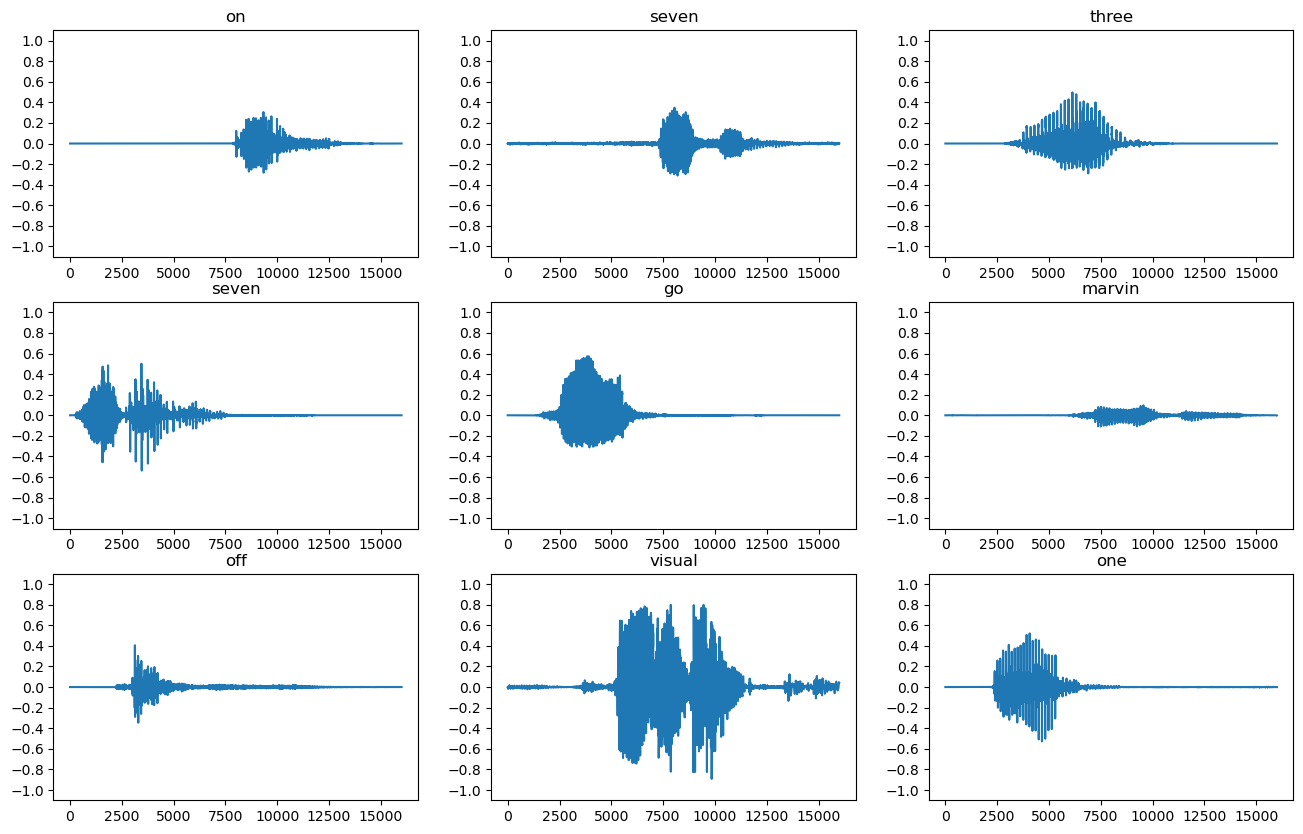

In [7]:
train.element_spec
# single channel audio
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train = train.map(squeeze, tf.data.AUTOTUNE)
val = val.map(squeeze, tf.data.AUTOTUNE)

# make test dataset
test_ds = val.shard(num_shards=2, index=0)
val_ds = val.shard(num_shards=2, index=1)

for example_audio, example_labels in train.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


In [8]:
# convert to spectrogram


def spectrogram(wave):
    # Convert the waveform to a spectrogram via a Short-time fourier transform.
  s = tf.signal.stft(
      wave, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  s = tf.abs(s)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  s = s[..., tf.newaxis]
  return s

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  s = spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', s.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: on
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: seven
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


2024-11-06 21:25:03.915926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:67: Filling up shuffle buffer (this may take a while): 750 of 10000
2024-11-06 21:25:13.895450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:67: Filling up shuffle buffer (this may take a while): 1096 of 10000
2024-11-06 21:25:17.228176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


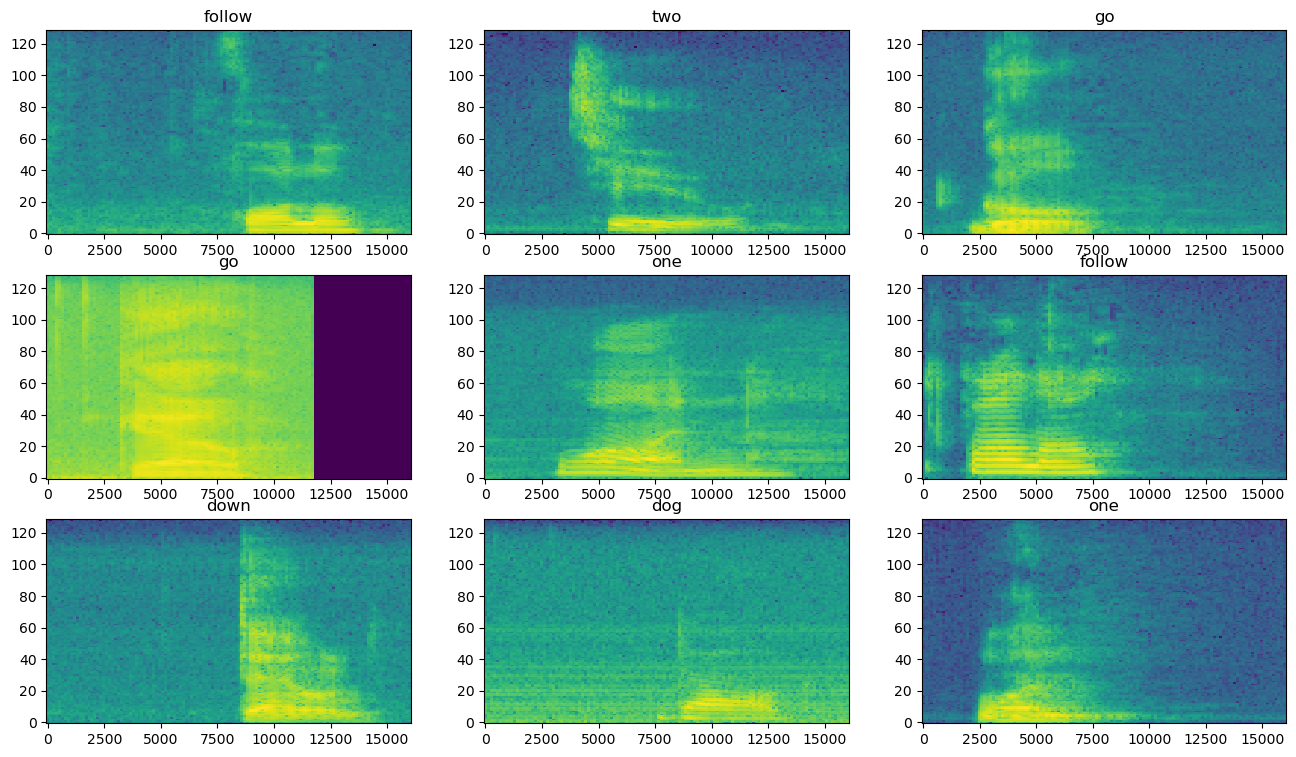

In [13]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


train_spectrogram_ds = make_spec_ds(train)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = keras.models.Sequential([
    keras.layers.Input(shape=input_shape),
    # Downsample the input.
    keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,223 (6.21 MB)

 Trainable params: 1,629,220 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [16]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 124s 92ms/step - accuracy: 0.2835 - loss: 2.5898 - val_accuracy: 0.6998 - val_loss: 1.0634
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 131s 99ms/step - accuracy: 0.6177 - loss: 1.2973 - val_accuracy: 0.7607 - val_loss: 0.8411
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 149s 113ms/step - accuracy: 0.6817 - loss: 1.0632 - val_accuracy: 0.7908 - val_loss: 0.7100
Epoch 4/10
 106/1323 ━━━━━━━━━━━━━━━━━━━━ 2:14 110ms/step - accuracy: 0.7241 - loss: 0.9226

KeyboardInterrupt: 